In [18]:
import os
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from FeatureAcquisition import FeatureAcquisition
from Predictor import Predictor
from Generators import GaussianSampler

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from PartialVAE import *

In [19]:
# 하나의 샘플에서 k개가 관측되었다고 가정
# k개의 관측을 임의로 배정

def sample_mask_uniform_K_per_sample(bs, d, min_K, max_K): # batch size, feature 개수, 최소 관측 샘플 수, 최대 관측 샘플 수
    m = np.zeros((bs, d), dtype=np.float32)
    Ks = np.random.randint(min_K, max_K+1, size=(bs,))
    for i, K in enumerate(Ks): # Ks의 index와 해당 index의 값
        idx = np.random.choice(d, size=K, replace=False)
        m[i, idx] = 1.0
    return m

## CUBE Experiments

In [20]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data", "Cube")

dataset_dict = torch.load(f"{DATA_DIR}/dataset_dict.pt")
X_train = torch.load(f"{DATA_DIR}/X_train.pt").float()
X_val   = torch.load(f"{DATA_DIR}/X_val.pt").float()
y_train = torch.load(f"{DATA_DIR}/y_train.pt").long()
y_val   = torch.load(f"{DATA_DIR}/y_val.pt").long()

In [21]:
feature_dim = 20 
num_classes = 8 
hidden_dim = 32 
predictor = Predictor(feature_dim, num_classes, hidden_dim)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
epochs = 10
lr = 1e-3
weight_decay = 1e-4

In [23]:
D = 20  # feature 개수 고정
predictor = predictor.to(device)
opt = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
crit = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

In [ ]:
for ep in range(1, epochs + 1):
    predictor.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        m_np = sample_mask_uniform_K_per_sample(bs=xb.size(0), d=D, min_K=1, max_K=D)
        mb = torch.tensor(m_np, dtype=torch.float32, device=device)

        logits = predictor(xb, mb)
        loss = crit(logits, yb)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        opt.step()

        total_loss += loss.item() * xb.size(0)

    predictor.eval()
    with torch.no_grad():
        xv, yv = X_val.to(device), y_val.to(device)

        # 각 샘플마다 랜덤 K로 마스크 생성 (학습과 동일)
        m_np = sample_mask_uniform_K_per_sample(bs=xv.size(0), d=D, min_K=1, max_K=D)
        mv = torch.tensor(m_np, dtype=torch.float32, device=device)

        probs_val = predictor(xv, mv)
        preds = probs_val.argmax(dim=-1)
        acc = (preds == yv).float().mean().item()

In [ ]:
X_test = torch.load(f"{DATA_DIR}/X_test.pt").float()
y_test = torch.load(f"{DATA_DIR}/y_test.pt").long()

device = next(predictor.parameters()).device
predictor.eval()

Predictor(
  (fc1): Linear(in_features=40, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Gaussian

In [ ]:
D = X_test.size(1)
N = X_test.size(0)
x_np = X_test.cpu().numpy()
m_np = np.zeros((N, D), dtype=np.float32)

generator = GaussianSampler(mean=0.0, std=1.0)

aurocs = []

for t in range(1, D+1):
    FA = FeatureAcquisition(
        x=x_np,
        m=m_np,
        generative_model=generator,
        num_samples=10,
        predictor=predictor,
        alpha=1.0,
        gamma=0.5
    )
    m_np, selected = FA.acquire()

    with torch.no_grad():
        print(m_np[10]) # 하나의 샘플에서 mask 1개씩 잘 고르는지 확인
        xv = X_test.to(device)
        mv = torch.tensor(m_np, dtype=torch.float32, device=device)
        logits = predictor(xv, mv)
        probs  = F.softmax(logits, dim=-1).cpu().numpy()

    y_true = y_test.cpu().numpy()
    auc = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    aurocs.append(auc)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0. 1. 1

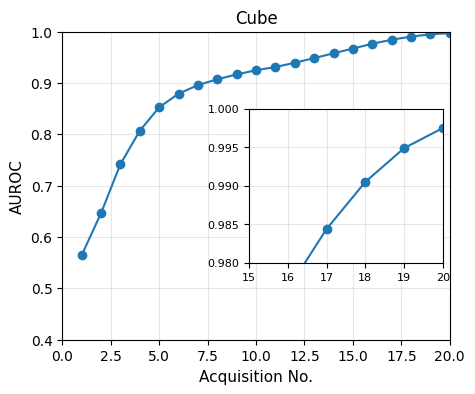

In [ ]:
# ===== 시각화 =====
plt.figure(figsize=(5,4))                # 그림 크기 비슷하게
plt.plot([i for i in range(1, D+1)], aurocs, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('AUROC', fontsize=11)
plt.title('Cube', fontsize=12)
plt.xlim(0, 20)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# inset (확대 영역)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = plt.gca()
axins = inset_axes(ax, width="50%", height="50%", loc='center right')

axins.plot([i for i in range(1, D+1)], aurocs, marker='o')
axins.set_xlim(15, 20)
axins.set_ylim(0.98, 1.00)
axins.grid(True, alpha=0.3)
axins.tick_params(labelsize=8)

plt.show()

In [ ]:
mean_auc = np.nanmean(aurocs)
print(f"Mean AUROC over all acquisitions = {mean_auc:.4f}")

Mean AUROC over all acquisitions = 0.8913


### Partial VAE

[PVAE ep 00] loss=0.2014  KL=0.1091  NLL_X=0.0923
[PVAE ep 01] loss=0.0573  KL=0.0004  NLL_X=0.0569
[PVAE ep 02] loss=0.0568  KL=0.0002  NLL_X=0.0566
[PVAE ep 03] loss=0.0564  KL=0.0001  NLL_X=0.0563
[PVAE ep 04] loss=0.0563  KL=0.0001  NLL_X=0.0562
[PVAE ep 05] loss=0.0560  KL=0.0001  NLL_X=0.0560
[PVAE ep 06] loss=0.0562  KL=0.0000  NLL_X=0.0562
[PVAE ep 07] loss=0.0559  KL=0.0000  NLL_X=0.0559
[PVAE ep 08] loss=0.0560  KL=0.0000  NLL_X=0.0559
[PVAE ep 09] loss=0.0558  KL=0.0000  NLL_X=0.0558


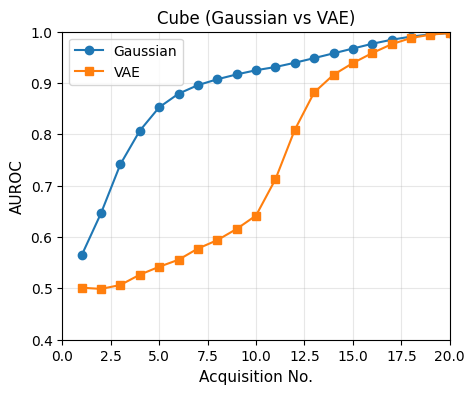

In [ ]:
# =========================
# 1) VAE 학습 준비 (continuous only)
# =========================
from torch.optim import AdamW

# VAE 하이퍼파라미터 (필요시 조정)
c_dim       = 32
hid_enc     = 128
hid_dec     = 128
latent_dim  = 16
hidden_dim_con = 128   # ContinuousXtoC의 hidden_dim
obs_sigma   = 1.0

# 연속형만 사용할 것이므로 분해 확인
Dcon = 20          # 20
Dcat = 0
Cmax = 0

pvae = PartialVAE(
    input_type="continuous",
    num_con_features=Dcon,
    num_cat_features=Dcat,
    hidden_dim_con=hidden_dim_con,
    most_categories=max(1, Cmax),   # 내부 선형차원 계산을 위해 최소 1
    c_dim=c_dim,
    hid_enc=hid_enc,
    hid_dec=hid_dec,
    latent_dim=latent_dim
).to(device)

opt_p = AdamW(pvae.parameters(), lr=1e-3, weight_decay=1e-4)

# 학습용 DataLoader (이미 위에서 train_loader 존재하면 그대로 사용해도 됨)
train_ds_p = TensorDataset(X_train, torch.ones_like(X_train[:, :1]))  # dummy second tensor
train_loader_p = DataLoader(train_ds_p, batch_size=batch_size, shuffle=True, drop_last=False)

# =========================
# 2) VAE 학습 루프
#    - 무작위 K-마스크를 배치마다 샘플링 (학습 시 입력/손실 마스크 동일)
# =========================
epochs_pvae = 10
pvae.train()
for ep in range(epochs_pvae):
    total_loss, total_kl, total_nll = 0.0, 0.0, 0.0
    count = 0
    for xb, _ in train_loader_p:
        xb = xb.to(device).float()
        bs = xb.size(0)
        m_np = sample_mask_uniform_K_per_sample(bs=bs, d=Dcon, min_K=1, max_K=Dcon)
        mb = torch.tensor(m_np, dtype=torch.float32, device=device)

        loss, logs = pvae.loss_func(xb, mb, obs_sigma=obs_sigma, n_samples=1)

        opt_p.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pvae.parameters(), 1.0)
        opt_p.step()

        total_loss += loss.item() * bs
        total_kl   += logs["KL"].item() * bs
        total_nll  += logs["NLL_X"].item() * bs
        count      += bs
    print(f"[PVAE ep {ep:02d}] loss={total_loss/count:.4f}  KL={total_kl/count:.4f}  NLL_X={total_nll/count:.4f}")

# =========================
# 3) 생성기 래퍼: FeatureAcquisition이 기대하는 .generate(x, m) 인터페이스
# =========================
class VAEGenerator:
    def __init__(self, pvae_model, obs_sigma=1.0, stochastic=False, n_samples=1, device="cpu"):
        self.model = pvae_model
        self.obs_sigma = obs_sigma
        self.stochastic = stochastic      # True면 평균 대신 Normal(mean, obs_sigma)에서 샘플
        self.n_samples = n_samples        # stochastic일 때만 의미 있음
        self.device = device

    @torch.no_grad()
    def generate(self, x: np.ndarray, m: np.ndarray) -> np.ndarray:
        """
        x: (N, D) numpy (관측된 값 포함)
        m: (N, D) numpy (관측=1, 미관측=0)
        return: (N, D) numpy (미관측 위치만 대체)
        """
        self.model.eval()
        xt = torch.tensor(x, dtype=torch.float32, device=self.device)
        mt = torch.tensor(m, dtype=torch.float32, device=self.device)
        # 한 번의 forward로 재구성 평균 얻기
        x_hat, (mu, sig) = self.model(xt, mt, n_samples=1)    # (N, D)
        if self.stochastic:
            # 평균을 중심으로 Normal에서 샘플 (관측 노이즈를 단순화해서 사용)
            eps = torch.randn_like(x_hat)
            x_samp = x_hat + self.obs_sigma * eps
            x_fill = mt * xt + (1 - mt) * x_samp
        else:
            x_fill = mt * xt + (1 - mt) * x_hat
        return x_fill.detach().cpu().numpy()

# 래퍼 생성 (평균 대치: deterministic)
vae_generator = VAEGenerator(pvae_model=pvae, obs_sigma=obs_sigma, stochastic=False, device=device)


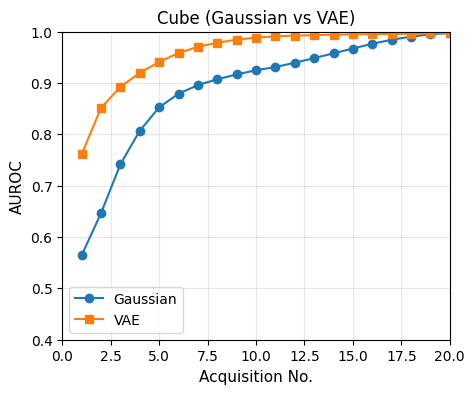

Gaussian Mean AUROC: 0.8913
VAE Mean AUROC:      0.9597


In [ ]:
# =========================
# 4) 기존 FeatureAcquisition 루프 재사용 (GaussianSampler → VAEGenerator로 교체)
# =========================
predictor.eval()
N = X_test.size(0)
D = X_test.size(1)
x_np = X_test.cpu().numpy()
m_np = np.zeros((N, D), dtype=np.float32)

aurocs_vae = []
for t in range(1, D+1):
    FA = FeatureAcquisition(
        x=x_np,
        m=m_np,
        generative_model=vae_generator,  # <<---- 교체
        num_samples=10,                  # 내부에서 필요 시 사용; 현재 래퍼는 평균 대치
        predictor=predictor,
        alpha=1.0,
        gamma=0.5
    )
    m_np, selected = FA.acquire()

    with torch.no_grad():
        xv = X_test.to(device)
        mv = torch.tensor(m_np, dtype=torch.float32, device=device)
        logits = predictor(xv, mv)
        probs  = F.softmax(logits, dim=-1).cpu().numpy()

    y_true = y_test.cpu().numpy()
    auc = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    aurocs_vae.append(auc)

# ===== 시각화 (VAE 결과도 같이 표시)
plt.figure(figsize=(5,4))
plt.plot(range(1, D+1), aurocs, marker='o', label='Gaussian')
plt.plot(range(1, D+1), aurocs_vae, marker='s', label='VAE')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('AUROC', fontsize=11)
plt.title('Cube (Gaussian vs VAE)', fontsize=12)
plt.xlim(0, D)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ===== 평균 AUROC 출력 =====
print(f"Gaussian Mean AUROC: {np.mean(aurocs):.4f}")
print(f"VAE Mean AUROC:      {np.mean(aurocs_vae):.4f}")